# 4.0 - Comparison of Km plots for 20% and 50% enriched

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import patches

from lifelines import KaplanMeierFitter, statistics
from tqdm import tqdm

In [29]:
PROJECT = "LIHC"

expressions = pd.read_csv(
    f"../tcga-data/data/TCGA-{PROJECT}.csv", sep=",", index_col=[0]
)
expressions = expressions[~expressions.index.duplicated(keep=False)]

expressions.index.name = "sample"

metadata = expressions[["time", "event"]]
expressions = expressions[expressions.columns[2:]]

ssgsea = pd.read_csv(f"../data/Hallmarks-nostd/TCGA-{PROJECT}-ssGSEA.tsv", sep="\t", index_col=[0])

In [3]:
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from src.ssGSEA.ssGSEA_related import get_GSEA_genesets
from single_sample_gsea import ss_gsea as ssGSEA
from src.stats.rmst import calculate_RMST_for_one_dataset, fit_KM_sequence, difference_RMST

hallmark_genesets = get_GSEA_genesets(expressions.columns.values, "h.all.v2023.1.Hs.symbols.gmt","../")

In [4]:
def normalize(expressions):
    exp = np.log(expressions.T + 1)
    exp = (exp - exp.mean(axis=0)) / exp.std(axis=0)
    exp = exp.dropna(axis=1)
    exp = exp.fillna(0)
    return exp.T

def fast_split_by_median(
    feature, feature_values, sorted_time, sorted_events, TIME_LIMIT, percentile_cutoff=50
):
    # Split values by median
    cutoff = np.percentile(feature_values, 100 - percentile_cutoff)
    strata = (feature_values > cutoff).astype(bool).flatten()

    # Check if the highest time in strata is lower than time limit
    #   If so, RMST would be undefined or misleading at best.
    time_limit = min(sorted_time[strata].max(), sorted_time[~strata].max())

    limit_is_lower = True
    if TIME_LIMIT <= time_limit:
        time_limit = TIME_LIMIT
    else:
        print("TIME_LIMIT is lower than maximal time in one of the cohorts.")
        limit_is_lower = False

    # creates KM sequences for both strata
    km1 = fit_KM_sequence(strata, sorted_events)
    km2 = fit_KM_sequence(~strata, sorted_events)

    # calculates the difference between those
    dif_rstm = difference_RMST(
        km1, km2, list(sorted_time[sorted_time <= time_limit]) + [time_limit]
    )

    return (feature, dif_rstm, limit_is_lower)


def bootstrap_logrank_values(
    ssgsea, metadata, M_BOOTSTRAP, geneset, split_perc, seed=0, add_rmst=False
):
    np.random.seed(seed)

    s = ssgsea[geneset].to_frame()
    m = metadata.loc[s.index.values]

    bootstrap_values = []

    for _ in range(M_BOOTSTRAP if M_BOOTSTRAP != False else 1):

        if M_BOOTSTRAP != False:
            ids = np.random.choice(np.arange(len(s)), size=len(s), replace=True)
            s_boot = s.iloc[ids]
            m_boot = m.iloc[ids]

            s_boot.index = np.arange(len(ids))
            m_boot.index = np.arange(len(ids))
        else:
            s_boot = s.copy()
            m_boot = m.copy()

        up_ids = s_boot[geneset] > np.percentile(ssgsea[geneset], 100 - split_perc)
        up_score = m_boot.loc[up_ids]
        down_score = m_boot.loc[~up_ids]

        m_boot = m_boot.sort_values(by=["time"])
        s_boot = s_boot.loc[m_boot.index.values]
        TIME_LIMIT = np.quantile(m_boot["time"], 0.75)

        logrank =  statistics.logrank_test(
                        up_score["time"],
                        down_score["time"],
                        event_observed_A=up_score["event"],
                        event_observed_B=down_score["event"],
                    )
        
        if add_rmst:
            rmst = fast_split_by_median(
                    "name", s_boot.values,
                    m_boot["time"].values,
                    m_boot["event"].values,
                    TIME_LIMIT=TIME_LIMIT,
                    percentile_cutoff=split_perc
                )[1]
            bootstrap_values += [(logrank, rmst)]
        else:
            bootstrap_values += [logrank]

        if M_BOOTSTRAP == False:
            break

    return bootstrap_values


def ssgsea_logrank_with_bootstrap_splits(
    expressions, metadata, genesets, M_BOOTSTRAP=1000, rnd_seed=0, splits=[50], add_rmst=False
) -> dict:

    exp = expressions.T
    exp.index.name = "gene"
    ssgsea = ssGSEA(exp, genesets)
    metadata = metadata.loc[ssgsea.index.values]

    results = {}

    for geneset in genesets.keys():

        results[geneset] = {}

        for split_perc in tqdm(splits):

            results[geneset][split_perc] = {}

            up_ids = ssgsea[geneset] > np.percentile(
                ssgsea[geneset].values, 100 - split_perc
            )
            up_score = metadata.loc[up_ids]
            down_score = metadata.loc[~up_ids]

            results[geneset][split_perc]["truth"] = statistics.logrank_test(
                up_score["time"],
                down_score["time"],
                event_observed_A=up_score["event"],
                event_observed_B=down_score["event"],
            )

            results[geneset][split_perc]["bootstrap"] = bootstrap_logrank_values(
                ssgsea, metadata, M_BOOTSTRAP, geneset, split_perc, rnd_seed, add_rmst
            )

    return results

In [7]:
SPLITS = np.arange(5, 100, 5)
geneset = "HALLMARK_MTORC1_SIGNALING"
GENESETS = {geneset: hallmark_genesets[geneset]}

results = ssgsea_logrank_with_bootstrap_splits(
    expressions, metadata, GENESETS, M_BOOTSTRAP=100, rnd_seed=1, splits=SPLITS
)

100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


In [8]:
exp = expressions.T
exp.index.name = "gene"
ssgsea = ssGSEA(exp, GENESETS)
metadata = metadata.loc[ssgsea.index.values]

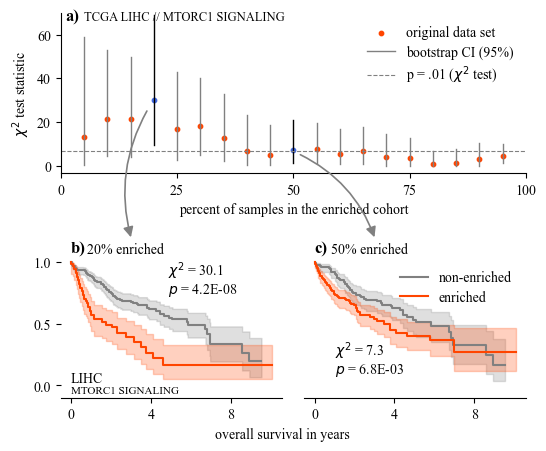

In [19]:
plt.rcParams["font.family"] = "Times New Roman"

f, axs = plt.subplots(2, 2, figsize=(6, 5), gridspec_kw={"wspace": 0.1, "hspace": 0.4})

gs = axs[0, 1].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axbig = f.add_subplot(gs[0, :])
ax = axs[1]

split_percentiles = [20, 50]


# top plot

for x in results[geneset].keys():

    truth = results[geneset][x]["truth"]
    boots = results[geneset][x]["bootstrap"]
    boots_values = [x.test_statistic for x in boots]

    axbig.scatter(
        x,
        truth.test_statistic,
        s=10,
        color="orangered" if x not in split_percentiles else "royalblue",
        label=None if x != 5 else "original data set",
    )

    CI_LOW = np.percentile(boots_values, 2.5)
    CI_HIGH = np.percentile(boots_values, 97.5)
    axbig.plot(
        [x, x],
        [CI_LOW, CI_HIGH],
        color="gray" if x not in split_percentiles else "k",
        lw=1,
        label=None if x != 5 else "bootstrap CI (95%)",
    )

axbig.axhline(
    6.635, 0, 100, ls="dashed", lw=0.8, color="gray", label="p = .01 ($\chi^2$ test)"
)
axbig.set_ylim(top=70)
axbig.legend(fontsize=10, frameon=False, labelspacing=0.4, loc=1)

axbig.set_ylabel("$\chi^2$ test statistic", fontsize=10)
axbig.set_xlabel("percent of samples in the enriched cohort", fontsize=10)

axbig.text(
    5,
    65,
    f"TCGA {PROJECT} // {' '.join(geneset.split('_')[1:])}",
    fontsize=9,
    verticalalignment="bottom",
    horizontalalignment="left",
)

_ = axbig.set_xticks(np.arange(0, 101, 25))

axbig.text(1, 64.7, "a)", fontsize=12, verticalalignment="bottom", weight="bold")

axbig.spines["top"].set_visible(False)
axbig.spines["right"].set_visible(False)


# Bottom plots

FOUR_YEARS = 4 * 365
RIGHT_XTICK = np.array([2, 2])
AXES_LABELS = list("bc")

text_loc = {
    0: [5*356, 0.75],
    1: [1*365, 0.1],
}

for i in range(2):

    group = ssgsea[geneset] > np.percentile(ssgsea[geneset], 100 - split_percentiles[i])
    group_names = ["non-enriched", "enriched"]  # for 0 and 1

    # PLOT KM
    T = metadata["time"]
    E = metadata["event"]

    kmf = KaplanMeierFitter()
    kmf.fit(T[-group], event_observed=E[-group], label=group_names[0])
    kmf.plot_survival_function(ax=ax[i], color="gray")

    kmf.fit(T[group], event_observed=E[group], label=group_names[1])
    kmf.plot_survival_function(ax=ax[i], color="orangered")

    logrank = statistics.logrank_test(
        T[-group], T[group], E[-group], E[group],
    )

    ax[i].text(text_loc[i][0], text_loc[i][1],
               r"$\chi^2$"f" = {logrank.test_statistic:.1f}\n" + r"$p$" + f" = {logrank.p_value:.1E}",
               linespacing=1)

    # adjust plots
    ax[i].set_ylim(-0.1, 1.2)

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    ax[i].set_yticks([0, 0.5, 1])
    ax[i].set_xticks(np.array([0, RIGHT_XTICK[i] // 2, RIGHT_XTICK[i]]) * FOUR_YEARS)
    ax[i].set_xticklabels(np.array([0, RIGHT_XTICK[i] // 2, RIGHT_XTICK[i]]) * 4)

    ax[i].text(0, 1.05, f"{AXES_LABELS[i]})", fontsize=12, verticalalignment="bottom", weight="bold")
    ax[i].text(
        0.2 * FOUR_YEARS,
        1.05,
        f"{split_percentiles[i]}% enriched",
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="left",
    )

    if i == 0:
        ax[i].text(0, 0, PROJECT, fontsize=10, verticalalignment="bottom")
        ax[i].text(
            0, 0, " ".join(geneset.split("_")[1:]), fontsize=8, verticalalignment="top"
        )

    if i == 0:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(fontsize=10, frameon=False, loc=1, labelspacing=0.4, borderpad=0.5, title="  ")

    if i == 0:
        ax[i].set_xlabel("overall survival in years", fontsize=10, x=1)
    else:
        ax[i].set_xlabel(None)

    if i not in [0, 3]:
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])

# like suggested here: https://stackoverflow.com/questions/60807792/arrows-between-matplotlib-subplots
arrow_A = patches.ConnectionPatch(
    [18.5, 25],
    [3*365, 1.2],
    coordsA=axbig.transData,
    coordsB=ax[0].transData,
    color="gray",
    arrowstyle="-|>",
    mutation_scale=15,
    linewidth=1.2,
    connectionstyle="arc3,rad=+.2"
)
f.patches.append(arrow_A)

arrow_B = patches.ConnectionPatch(
    [51.5, 5],
    [3*365, 1.2],
    coordsA=axbig.transData,
    coordsB=ax[1].transData,
    color="gray",
    arrowstyle="-|>",
    mutation_scale=15,
    linewidth=1.2,
    connectionstyle="arc3,rad=-.2"
)
f.patches.append(arrow_B)


f.savefig("../figures/split-variation.pdf", bbox_inches="tight", dpi=500)